# A simple convex example with missing data, solved three ways

Bennet Meyers, 12/8/21

1. CVXPY + MOSEK
2. SD ADMM
3. Coordinate descent

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from time import time
import seaborn as sns
import cvxpy as cvx
sns.set_style('darkgrid')
import sys
sys.path.append('..')

In [3]:
from osd import Problem
from osd.components import MeanSquareSmall, SmoothSecondDifference, SparseFirstDiffConvex
from osd.signal_decomp_bcd import run_bcd
from osd.utilities import progress
from osd.signal_decomp_admm import calc_obj

In [4]:
TOL = 1e-5

## Data generation

In [46]:
np.random.seed(42)
t = np.linspace(0, 1000, 200)
signal1 = np.sin(2 * np.pi * t * 1 / (500.))
signal2 = signal.square(2 * np.pi * t * 1 / (450.))
X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = 0.15 * np.random.randn(len(signal1))
X_real[1] = signal1
X_real[2] = signal2
y = np.sum(X_real, axis=0)
y[55:90] = np.nan
y[150:175] = np.nan
X_real[:, np.isnan(y)] = np.nan
# ixs = np.random.choice(np.arange(len(y)), len(y) // 4, replace=False)
# y[ixs] = np.nan
print(np.sum(~np.isnan(y)) / len(y))
K, T = X_real.shape

0.7


In [57]:
def make_masked_data():
    y, X_real = make_data()
    y[55:90] = np.nan
    y[270:360] = np.nan
    X_real[:, np.isnan(y)] = np.nan
    return y, X_real

def make_data():
    """
    a sine wave plus a square wave at a different frequency, and Gaussian noise
    """
    np.random.seed(42)
    t = np.linspace(0, 1000, 200)
    signal1 = np.sin(2 * np.pi * t * 1 / (500.))
    signal2 = signal.square(2 * np.pi * t * 1 / (450.))
    X_real = np.zeros((3, len(t)), dtype=float)
    X_real[0] = 0.15 * np.random.randn(len(signal1))
    X_real[1] = signal1
    X_real[2] = signal2
    y = np.sum(X_real, axis=0)
    return y, X_real

y, X_real = make_masked_data()

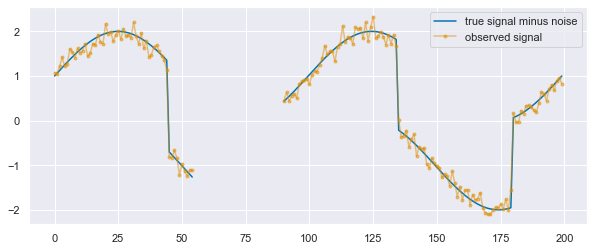

In [58]:
plt.figure(figsize=(10, 4))
plt.plot(np.sum(X_real[1:], axis=0), label='true signal minus noise')
plt.plot(y, alpha=0.5, marker='.', label='observed signal')
plt.legend()
plt.show()

# CVXPY + MOSEK

In [109]:
c1 = MeanSquareSmall(size=T)
c2 = SmoothSecondDifference(weight=1e3/T)
c3 = SparseFirstDiffConvex(weight=2e0/T, vmax=1, vmin=-1)
components = [c1, c2, c3]
problem1 = Problem(y, components)

In [110]:
problem1.decompose(how='cvx', verbose=True)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Jan 26 04:08:56 PM: Your problem has 600 variables, 3 constraints, and 3 parameters.
(CVXPY) Jan 26 04:08:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 26 04:08:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 26 04:08:56 PM: Compiling problem (target solver=OSQP).
(CVXPY) Jan 26 04:08:56 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Jan 26 04:08:56 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 26 04:08:56 PM: Applying reduction Qp2SymbolicQp

In [111]:
opt_obj_val = problem1.objective_value
opt_obj_val

0.08028127713698252

In [112]:
rms = lambda x: np.sqrt(np.average(np.power(x, 2)))

In [113]:
rms(problem1.estimates[0, problem1.use_set] - X_real[0, problem1.use_set])

0.13490148977146663

In [114]:
rms(problem1.estimates[1, problem1.use_set] - X_real[0, problem1.use_set])

1.0357304740510016

In [115]:
rms(problem1.estimates[2, problem1.use_set] - X_real[0, problem1.use_set])

0.8027000223957572

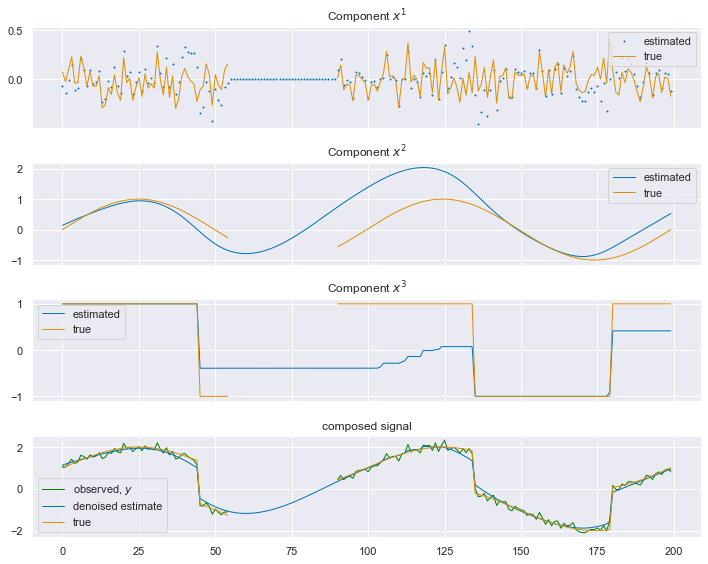

In [116]:
problem1.plot_decomposition(X_real=X_real);

In [121]:
problem1._problem_costs[2].value

0.043516632882064

In [122]:
problem1.components[2].cost(problem1.estimates[2]).value * problem1.components[2].weight

0.043516632882064

# SD ADMM

In [96]:
problem2 = Problem(y, components)
problem2.decompose(how='admm', num_iter=5e2, use_set=~np.isnan(y))
problem2.objective_value - opt_obj_val

Starting ADMM...
y shape: (200,)
X shape: (3, 200)
u shape: (165,)

[====================] ...286 iterations, 7.96 sec -- obj_val: 8.03e-02, r: 1.01e-05, tol: 1.02e-05      



-4.007609237119403e-06

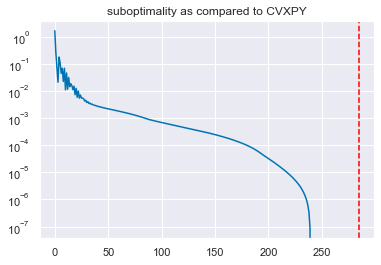

In [97]:
plt.figure()
plt.plot(problem2.admm_result['obj_vals'] - opt_obj_val)
plt.axvline(problem2.admm_result['it'], color='red', ls='--')
plt.title('suboptimality as compared to CVXPY')
plt.yscale('log')
plt.show()

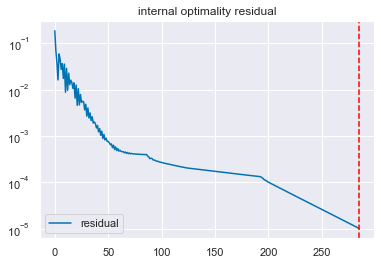

In [98]:
plt.figure()
plt.plot(problem2.admm_result['optimality_residual'], label='residual')
plt.axvline(problem2.admm_result['it'], color='red', ls='--')
plt.yscale('log')
plt.legend()
plt.title('internal optimality residual')
plt.show()

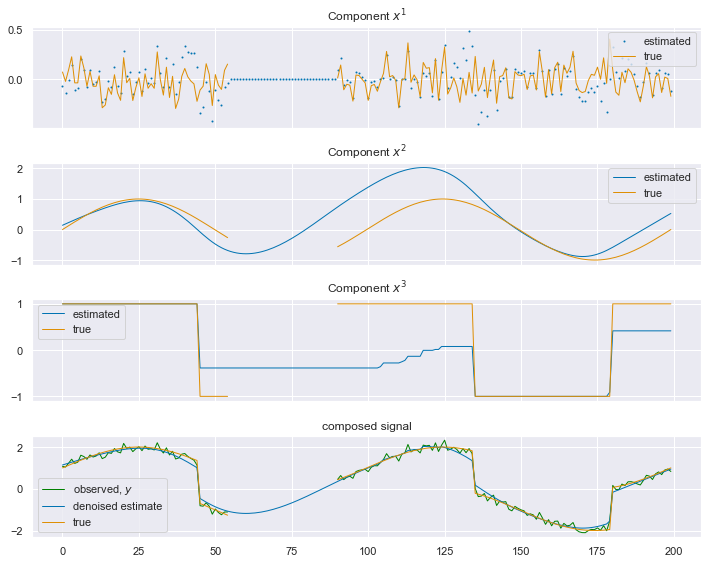

In [99]:
problem2.plot_decomposition(X_real=X_real);

# Coordinate Descent

In [100]:
problem3 = Problem(y, components)
problem3.decompose(how='bcd', stopping_tolerance=TOL, num_iter=5e2)
problem3.objective_value - opt_obj_val

Starting BCD...
y shape: (200,)
X shape: (3, 200)

[====================] ...103 iterations, 2.90 sec -- obj_val: 8.03e-02, r: 9.88e-06, tol: 1.02e-05      



-4.210128248804956e-06

In [101]:
len(problem3.bcd_result['obj_vals'])

103

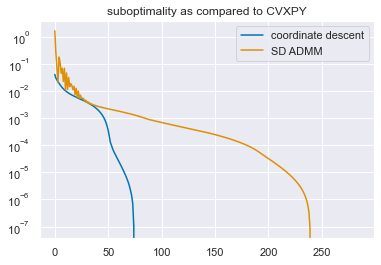

In [102]:
plt.figure()
plt.plot(problem3.bcd_result['obj_vals'] - opt_obj_val, label='coordinate descent')
plt.plot(problem2.admm_result['obj_vals'] - opt_obj_val, label='SD ADMM')
plt.title('suboptimality as compared to CVXPY')
plt.yscale('log')
plt.legend()
plt.show()

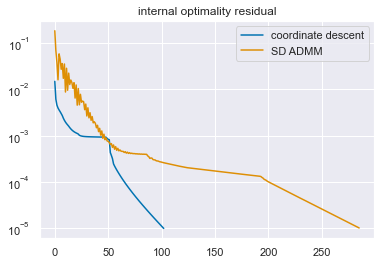

In [103]:
plt.figure()
plt.plot(problem3.bcd_result['optimality_residual'], label='coordinate descent')
plt.plot(problem2.admm_result['optimality_residual'], label='SD ADMM')
plt.yscale('log')
plt.title('internal optimality residual')
plt.legend()
plt.show()

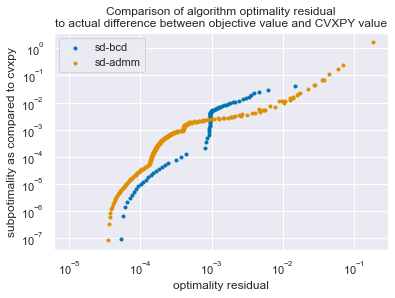

In [104]:
plt.scatter(problem3.bcd_result['optimality_residual'], problem3.bcd_result['obj_vals'] - opt_obj_val, 
            label='sd-bcd', marker='.')
plt.scatter(problem2.admm_result['optimality_residual'], problem2.admm_result['obj_vals'] - opt_obj_val, 
            label='sd-admm', marker='.')
plt.xscale('log')
plt.yscale('log')
# plt.xlim(plt.ylim())
plt.xlabel('optimality residual')
plt.ylabel('subpotimality as compared to cvxpy')
# plt.gca().set_aspect('equal')
plt.legend()
plt.title('Comparison of algorithm optimality residual\nto actual difference between objective value and CVXPY value');

### CVXPY solution

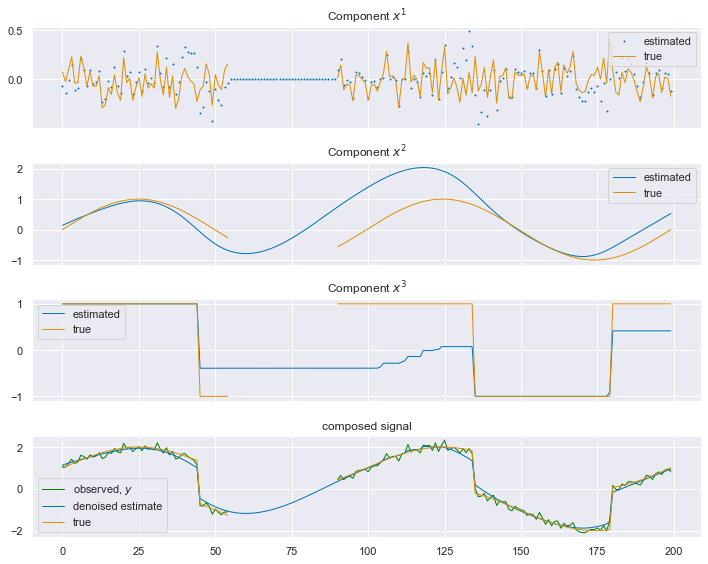

In [105]:
problem1.plot_decomposition(X_real=X_real);

### mprox-ADMM solution

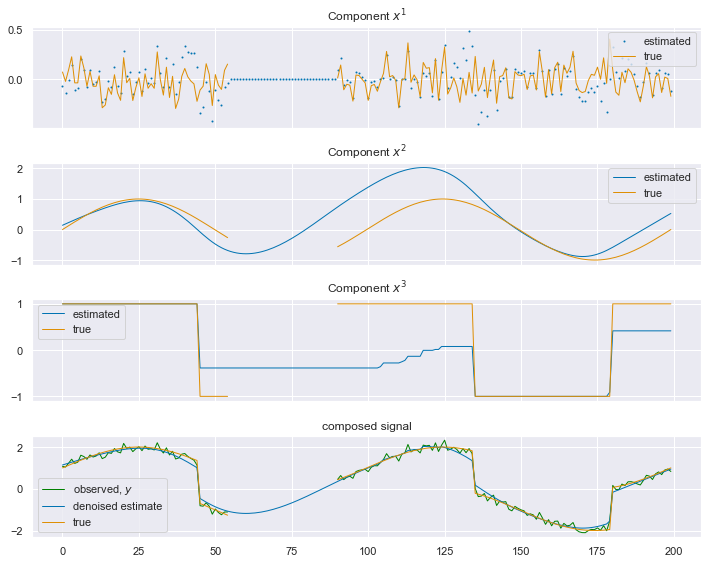

In [106]:
problem2.plot_decomposition(X_real=X_real);

### mprox-BCD solution

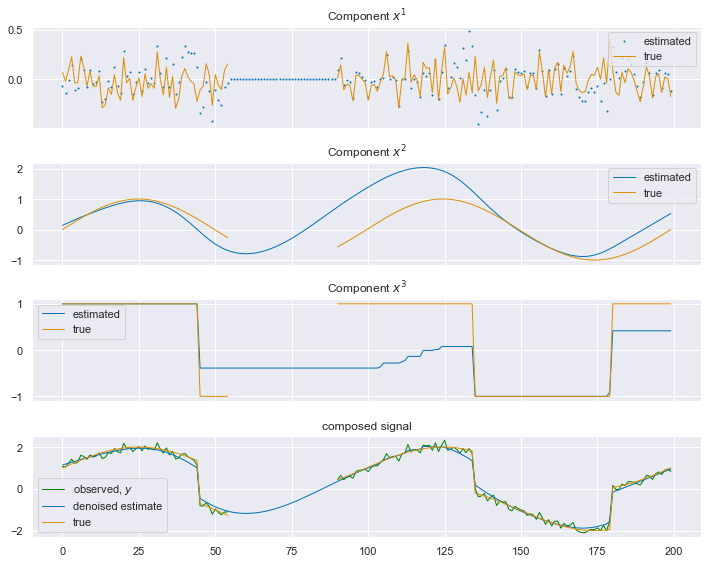

In [107]:
problem3.plot_decomposition(X_real=X_real);